# Import Libraries

In [72]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Import Data from .csv

In [73]:
# specify year interval for training data
init_year = 2015
end_year = 2019 # inclusive

df_list = []
for year in range(init_year, end_year + 1):
    df = pd.read_csv(f'../data/Prepared data/{str(year)}_features.csv')
    df_list.append(df)

df_raw = pd.concat(df_list, axis=0, ignore_index=True)

# Add Day Type (weekday, weekend, holiday)

In [74]:
import datetime
import holidays

def is_workday(date:datetime.date):
    """
    Determines the type of day (workday or not) for a given date.

    Args:
        date (datetime.date): The date to check.

    Returns:
        int: 1 if workday else 0.
    """
    # Get the US holidays
    us_holidays = holidays.US()

    # Check if the date is a holiday
    if date in us_holidays:
        return 0

    # Check if the date is a weekend
    if date.weekday() >= 5:  # Saturday is 5, Sunday is 6
        return 0

    # Otherwise, it's a weekday
    return 1


In [75]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['timestamp'] = pd.to_datetime(X['timestamp'])
        X['is_workday'] = X['timestamp'].apply(lambda x: is_workday(x.date()))
        X['year'] = X['timestamp'].dt.year
        X['month'] = X['timestamp'].dt.month
        X['day'] = X['timestamp'].dt.day
        X['hour'] = X['timestamp'].dt.hour
        X = X.drop('timestamp', axis=1)
        return X

In [76]:
df = df_raw[['timestamp', 'load', 'temp']].copy()
del df_raw

# Data Preprossing

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

timestamp_transformer = TimestampTransformer()
df = timestamp_transformer.transform(df)
imputer = SimpleImputer(strategy='mean')
df['load'] = imputer.fit_transform(df[['load']])
df['temp'] = imputer.fit_transform(df[['temp']])
scaler_temp = StandardScaler()
scaler_load = StandardScaler()
df['temp'] = scaler_temp.fit_transform(df[['temp']])
df['load'] = scaler_load.fit_transform(df[['load']])

# Make Dataset

In [78]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len=1, transform=None, target_transform=None):
        """
        Custom Dataset for multivariate time series.

        Args:
            df (pd.Dataframe): Assume the dataframe has been preprocessed and has only numeriacal values.
            seq_length (int): Length of each sequence.
            transform: Composition of transformations.
        """
        super(TimeSeriesDataset, self).__init__()
        self.df = df
        self.features = self.df.values
        self.targets = self.df['load'].values
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.features) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.seq_len, :]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        
        target = self.targets[idx + self.seq_len: idx + self.seq_len + self.pred_len]
        target = torch.tensor(target, dtype=torch.float32)
        
        return sequence, target

In [79]:
import numpy as np

dataset = TimeSeriesDataset(df, seq_len=288, pred_len=288)
train_size = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Make Dataloader

In [80]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Model Implementation

In [81]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

class SimpleGRU(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

# Training

In [82]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

In [83]:
import matplotlib.pyplot as plt

def evaluate_metrics(real_values, predictions): 
    ''' 
    Calculate evaluation metrics: MAE, MAPE, and R-squared. 

    Parameters 
    ---------- 

    real_values (array-like): The actual values. 
    predictions (array-like): The predicted values. 

    Returns 
    ------- 
    mae, mape, r_squared
    ''' 

    real_values = np.array(real_values) 
    predictions = np.array(predictions) 

    # Mean Absolute Error (MAE) 
    mae = np.mean(np.abs(real_values - predictions)) 

    # Mean Absolute Percentage Error (MAPE) 
    epsilon = 1e-6
    mape = np.mean(np.abs((real_values - predictions) / (real_values + epsilon))) * 100


    # R-squared 
    ss_res = np.sum((real_values - predictions) ** 2) 
    ss_tot = np.sum((real_values - np.mean(real_values)) ** 2) 
    r_squared = 1 - (ss_res / ss_tot)

    return mae, mape, r_squared

def model_evaluation(model, criterion, data_loader, device='cpu'):

    batch_losses = []

    model.eval() # switch to evalution mode
    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

    model.train() # switch to training mode

    loss_mean = np.mean(batch_losses)

    return loss_mean

def training_loop(n_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=False, scheduler=None, device='cpu', save_model=None, save_as='model.pt'):
    '''
    Set `verbose=True` to see scores for each epoch. If cuda is available, set `device='cuda'`.

    Return
    ------
    - train_losses (list): history of training loss
    - test_losses (list): history of test/validation loss
    '''
    train_losses = []
    test_losses = []

    min_test_loss = float('inf')
    for n in range(n_epochs):
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        if scheduler != None:
            scheduler.step() # update learning rate
        
        train_loss = model_evaluation(model, criterion, train_loader, device=device)
        test_loss = model_evaluation(model, criterion, test_loader, device=device)

        # save model with lowest test/validation loss
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            if save_model == 'best':
                torch.save(model.state_dict(), save_as)

        # save model at last epoch
        if save_model == 'last' and n == n_epochs - 1:
            torch.save(model.state_dict(), save_as)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if ((n + 1) % 10 == 0) or verbose:
            print(f'Epoch {n + 1}/{n_epochs}: Training loss {train_loss:.4f}, Validation Loss {test_loss:.4f}')
            if scheduler != None:
                print(f"Current learning rate is {scheduler.get_last_lr()[0]}")
            print('----------------------------------------------------------')

    return train_losses, test_losses

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1/50: Training loss 0.6260, Validation Loss 0.6916
----------------------------------------------------------
Epoch 2/50: Training loss 1.0147, Validation Loss 0.9513
----------------------------------------------------------
Epoch 3/50: Training loss 0.6177, Validation Loss 0.6940
----------------------------------------------------------
Epoch 4/50: Training loss 0.2754, Validation Loss 0.2977
----------------------------------------------------------
Epoch 5/50: Training loss 0.1837, Validation Loss 0.1992
----------------------------------------------------------
Epoch 6/50: Training loss 0.1709, Validation Loss 0.1790
----------------------------------------------------------
Epoch 7/50: Training loss 0.1921, Validation Loss 0.2185
----------------------------------------------------------
Epoch 8/50: Training loss 0.1450, Validation Loss 0.1626
----------------------------------------------------------
Epoch 9/50: Training loss 0.1424, Validation Loss 0.1652
---------------

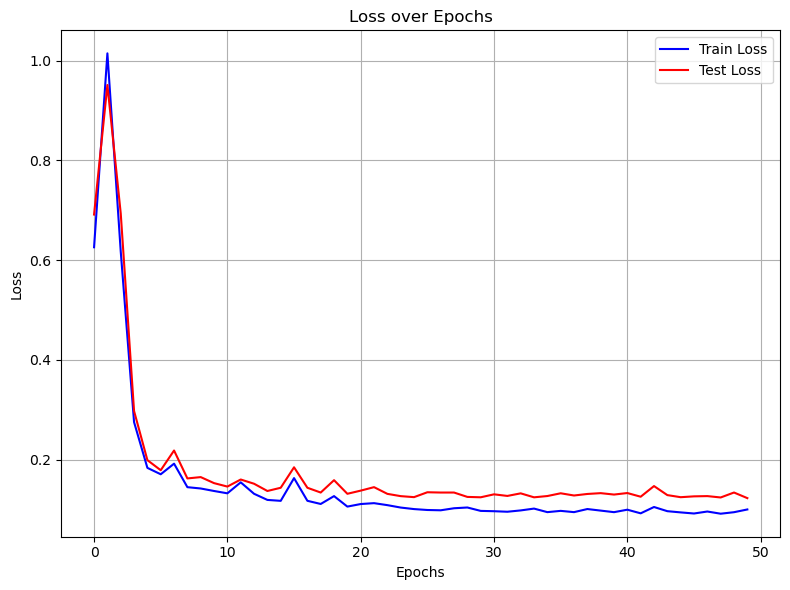

In [95]:
num_features = 7  # Number of features
output_size = 288
hidden_size = 64
num_layers = 2
num_epochs = 50
drop_rate = 0.3
lr_rate = 1e-4
weight_decay = 0
scheduler = None

lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers, drop_rate=drop_rate).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    lstm_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    scheduler=scheduler,
    device='cuda', 
    save_model='last', 
    save_as='LSTM.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

Epoch 1/50: Training loss 0.2596, Validation Loss 0.2899
----------------------------------------------------------
Epoch 2/50: Training loss 0.1606, Validation Loss 0.1726
----------------------------------------------------------
Epoch 3/50: Training loss 0.1319, Validation Loss 0.1509
----------------------------------------------------------
Epoch 4/50: Training loss 0.1429, Validation Loss 0.1509
----------------------------------------------------------
Epoch 5/50: Training loss 0.1186, Validation Loss 0.1440
----------------------------------------------------------
Epoch 6/50: Training loss 0.1189, Validation Loss 0.1502
----------------------------------------------------------
Epoch 7/50: Training loss 0.1156, Validation Loss 0.1357
----------------------------------------------------------
Epoch 8/50: Training loss 0.1221, Validation Loss 0.1317
----------------------------------------------------------
Epoch 9/50: Training loss 0.1106, Validation Loss 0.1362
---------------

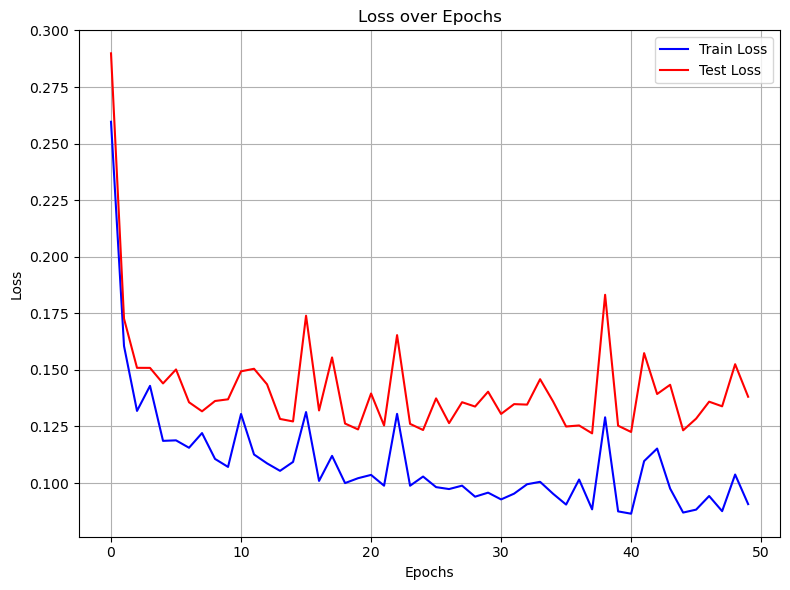

In [85]:
gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    gru_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    scheduler=scheduler,
    device='cuda', 
    save_model='last',
    save_as='GRU.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

# Make Predictions


In [96]:
# get 2020 data
df_2020_raw = pd.read_csv('../data/Prepared data/2020_features.csv')
df_2020 = df_2020_raw[['timestamp', 'load', 'temp']].copy()
del df_2020_raw
df_2020 = timestamp_transformer.transform(df_2020)
df_2020['temp'] = scaler_temp.transform(df_2020[['temp']])
df_2020['load'] = scaler_load.transform(df_2020[['load']])

In [87]:
def make_predictions(model, initial_data, future_data, pred_len, device='cuda'):
    '''
    Make multi-step predictions using a model that outputs `pred_len` steps at once.

    Parameters
    ----------
    model: Outputs multiple steps ahead (pred_len) at once.
    initial_data (tensor): The initial historical data (sequence) to start predictions from.
    future_data (tensor): Future features for each timestep. Has columns e.g., 'load', 'temp', 'is_workday', 'month', 'day', 'hour'.
                          The first column should be the 'load' placeholder (currently unknown future load).
    pred_len (int): The number of future steps the model predicts at each call.
    device (str): Device to run computations on ('cuda' or 'cpu').

    Returns
    -------
    predictions (list): List of predicted load values (normalized).
    '''

    initial_data = initial_data.to(device)
    future_data = future_data.to(device)

    predictions = []
    sequence = initial_data

    total_future_steps = len(future_data)
    start_idx = 0

    model.eval()
    with torch.no_grad():
        while start_idx < total_future_steps:
            # Run model to predict the next pred_len steps
            # Output shape: [1, pred_len]
            pred_loads = model(sequence.unsqueeze(0)).squeeze(0)  # shape: [pred_len]
            
            steps_to_predict = min(pred_len, total_future_steps - start_idx)
            
            # Store only the needed predictions if less than pred_len steps remain
            predicted_values = pred_loads[:steps_to_predict].cpu().tolist()
            predictions.extend(predicted_values)
            
            # For each predicted step, combine the predicted load with its corresponding future features
            new_rows = []
            for i in range(steps_to_predict):
                # pred_load is a single predicted value
                pred_load = pred_loads[i].unsqueeze(0).unsqueeze(0)  # shape: [1,1]
                # The future_data row has shape [features], the first feature is 'load', which we replace
                # with the predicted load. The rest of the columns remain from future_data.
                next_data = torch.cat([pred_load, future_data[start_idx + i, 1:].unsqueeze(0)], dim=1)  # shape: [1, features]
                new_rows.append(next_data)

            # Concatenate all new rows for this batch
            new_rows = torch.cat(new_rows, dim=0)  # shape: [steps_to_predict, features]

            # Update the sequence: discard the oldest steps and add the newly predicted steps
            seq_len = sequence.size(0)
            # Remove as many old steps as we add new steps, so sequence length remains constant
            sequence = torch.cat([sequence[steps_to_predict:], new_rows], dim=0)

            start_idx += steps_to_predict

    return predictions

def make_predictions_daliy_correction(model, initial_data, future_data, device='cuda'):
    '''
    Make multi-step predictions based on the length of future_data.

    Parameters
    ----------
    model: Assume trained.
    initial_data (tensor): The data to start the prediction. Assume data is normalized.
    future_data (tensor): Has 'load', 'temp', 'is_workday', 'month', 'day', 'hour' columns. Assume data is normalized.

    Returns
    -------
    predictions (list): List of predictions (normalized).
    '''
    
    initial_data = initial_data.to(device)
    future_data = future_data.to(device)

    predictions = []

    with torch.no_grad():
        sequence = initial_data
        real_seq = initial_data
        count = 0
        for i in range(len(future_data)):
            # make prediction
            next_load = model(sequence.unsqueeze(0))
            predictions.append(next_load.item())
            # combine with future data
            next_data = torch.cat([next_load, future_data[i, 1:].unsqueeze(0)], 1)
            # update sequence
            sequence = torch.cat([sequence[1:], next_data], 0)

            real_next_data = future_data[i].unsqueeze(0)
            real_seq = torch.cat([real_seq[1:], real_next_data], 0)

            count += 1
            if count == 288:
                # print(f'switch: {i}')
                sequence = real_seq
                
                count = 0
            
    
    return predictions

In [88]:
# Load saved models

# lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers).to('cuda')
# lstm_model.load_state_dict(torch.load('LSTM.pt', weights_only=True))
# lstm_model.eval()

# gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
# gru_model.load_state_dict(torch.load('GRU.pt', weights_only=True))
# gru_model.eval()

## Test on training dataset

In [98]:
initial_np = df.iloc[:288].to_numpy(dtype=np.float32)
initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
future_np = df.iloc[288:7*288].to_numpy(dtype=np.float32)
future_tensor = torch.tensor(future_np, dtype=torch.float32)

predictions_lstm = make_predictions(lstm_model, initial_tensor, future_tensor, pred_len=288, device='cuda')
predictions_gru = make_predictions(gru_model, initial_tensor, future_tensor, pred_len=288, device='cuda')

LSTM: MAE 0.5050279342269306, MAPE 129.02833818520622, R^2 0.42440844148609236
GRU: MAE 0.4151757573910774, MAPE 149.25449020879933, R^2 0.6560717651968102


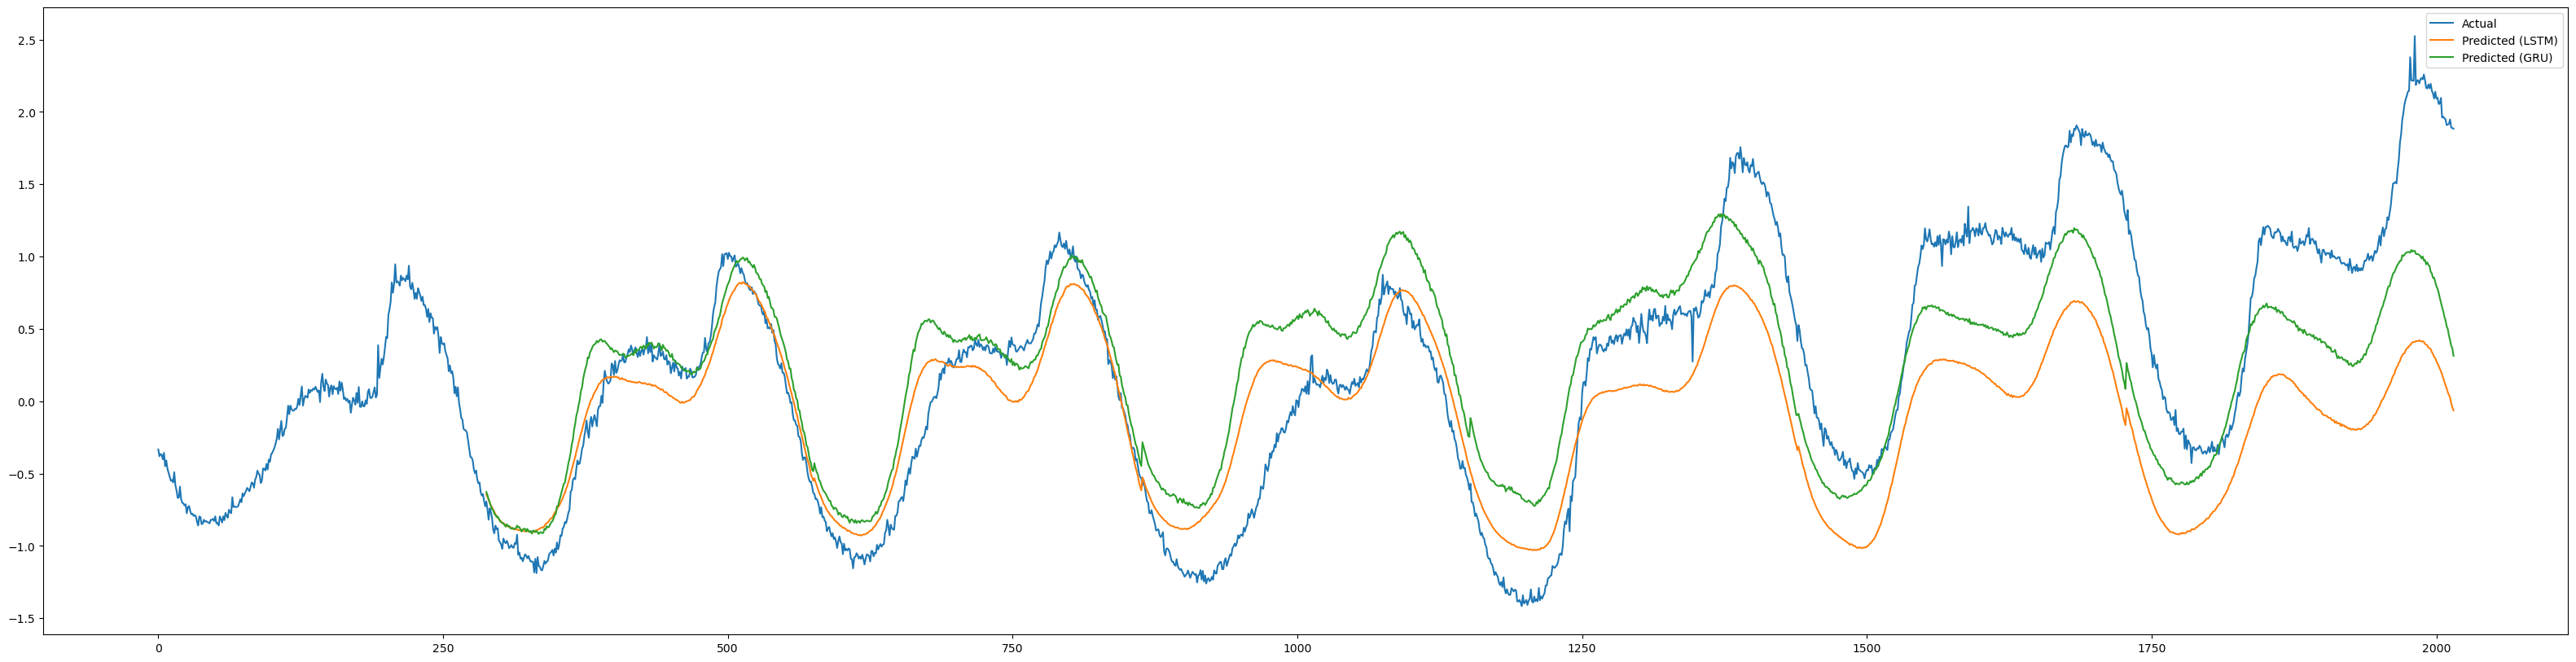

In [99]:
import matplotlib.pyplot as plt

initial = df.iloc[:288]['load'].values
future = df.iloc[288:7*288]['load'].values
actual = np.concatenate([initial, future])

lstm_scores = evaluate_metrics(future, predictions_lstm)
print(f'LSTM: MAE {lstm_scores[0]}, MAPE {lstm_scores[1]}, R^2 {lstm_scores[2]}')
gru_scores = evaluate_metrics(future, predictions_gru)
print(f'GRU: MAE {gru_scores[0]}, MAPE {gru_scores[1]}, R^2 {gru_scores[2]}')

plt.figure(figsize=(40,10))
plt.plot(actual, label='Actual')
# shift the predictions to align with the actual data
plt.plot([None]*288 + predictions_lstm, label='Predicted (LSTM)')
plt.plot([None]*288 + predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.show()

## Test on unseen data from 2021

In [100]:
initial_np = df.iloc[-288:].to_numpy(dtype=np.float32)
initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
future_np = df_2020.iloc[:7*288].to_numpy(dtype=np.float32)
future_tensor = torch.tensor(future_np, dtype=torch.float32)

predictions_lstm = make_predictions(lstm_model, initial_tensor, future_tensor, pred_len=288, device='cuda')
predictions_gru = make_predictions(gru_model, initial_tensor, future_tensor, pred_len=288, device='cuda')

LSTM: MAE 0.21861510714776353, MAPE 266.05177779481244, R^2 0.8073105157645072
GRU: MAE 0.20025270055062527, MAPE 205.7399462402787, R^2 0.8192865131377128


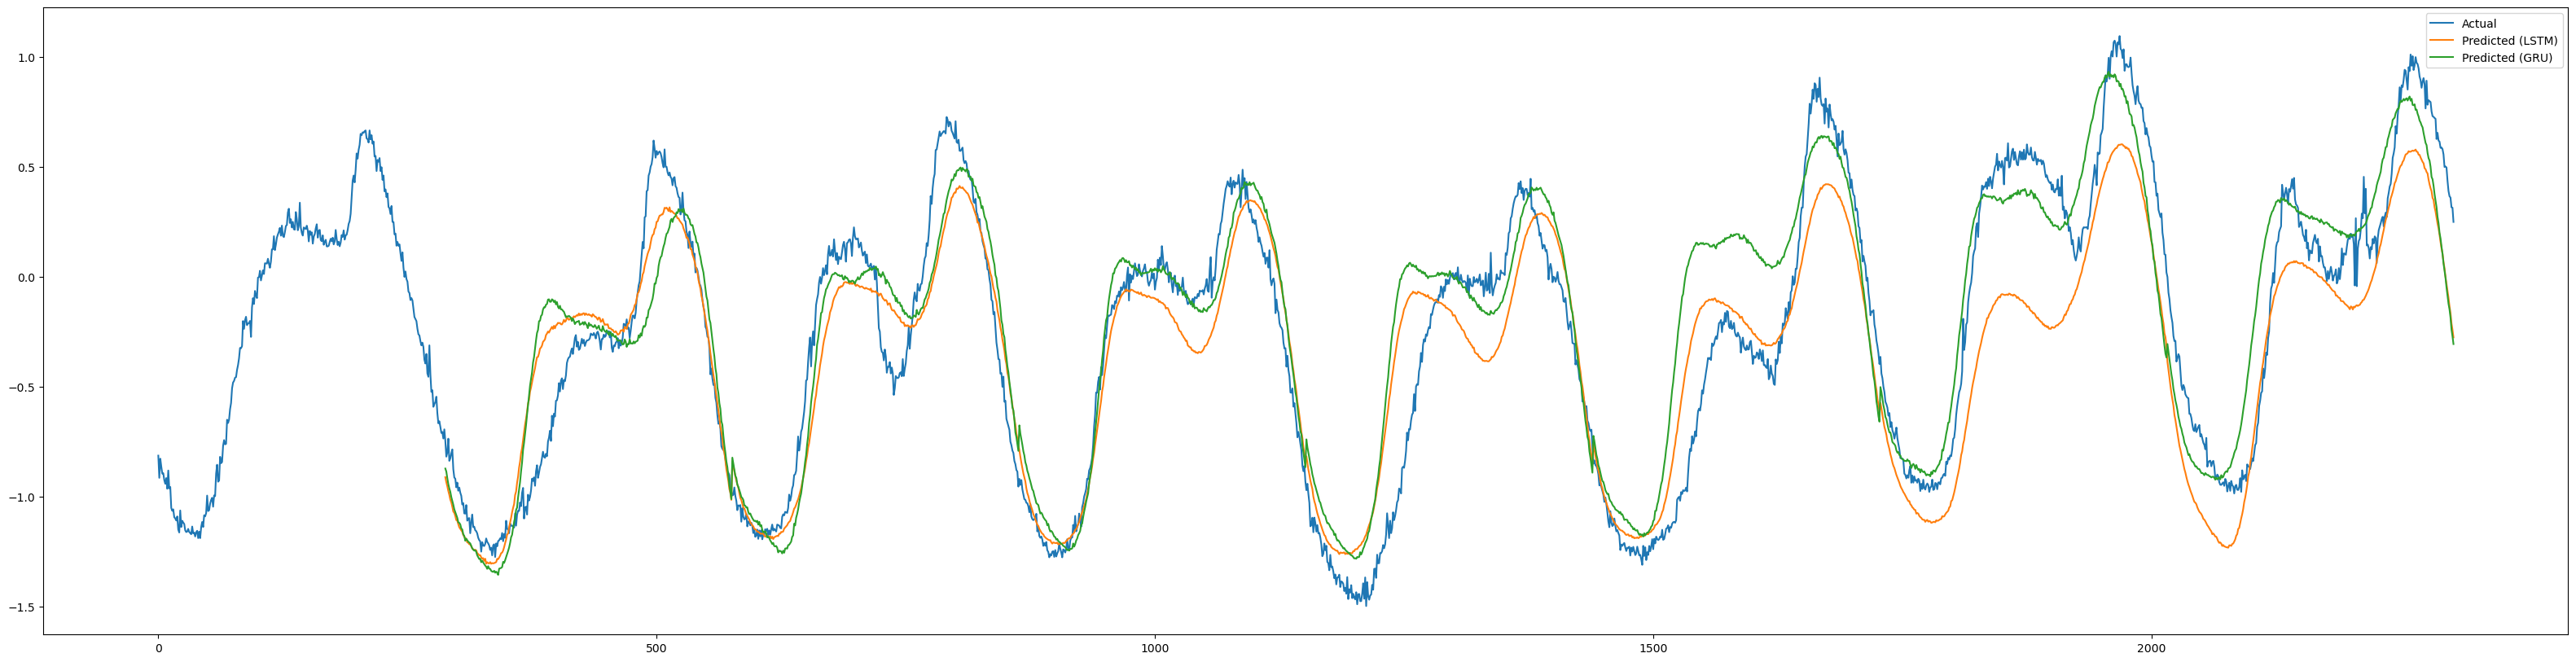

In [101]:
initial = df.iloc[-288:]['load'].values
future = df_2020.iloc[:7*288]['load'].values
actual = np.concatenate([initial, future])

lstm_scores = evaluate_metrics(future, predictions_lstm)
print(f'LSTM: MAE {lstm_scores[0]}, MAPE {lstm_scores[1]}, R^2 {lstm_scores[2]}')
gru_scores = evaluate_metrics(future, predictions_gru)
print(f'GRU: MAE {gru_scores[0]}, MAPE {gru_scores[1]}, R^2 {gru_scores[2]}')

plt.figure(figsize=(40, 10))
plt.plot(actual, label='Actual')
# shift the predictions to align with the actual data
plt.plot([None]*288 + predictions_lstm, label='Predicted (LSTM)')
plt.plot([None]*288 + predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.show()